In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import logging
import imp
from rpy2.robjects import numpy2ri

RANDOM_SEED = 0
numpy2ri.activate()

import fairtest.utils.log as fairtest_log
imp.reload(fairtest_log)
fairtest_log.set_params(filename='fairtest.log', level=logging.INFO)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
from fairtest import DataSource
import fairtest.investigation as inv
import fairtest.testing as testing
import fairtest.discovery as discovery
import fairtest.error_profiling as error_profiling
import fairtest.modules.metrics as metrics
import fairtest.modules.metrics.correlation as correlation
import fairtest.modules.metrics.regression as regression
import fairtest.modules.metrics.binary_metrics as binary_metrics
import fairtest.modules.statistics.confidence_interval as intervals
import ast
import numpy as np
import sklearn.preprocessing as preprocessing
from collections import Counter

dataname = 'medical'
data = pd.read_csv(
            '../data/medical/predictions_reg_log.csv',
            header=0,
            sep=r'\s*,\s*',
            engine='python',
            na_values="?")
TARGET = 'Prediction'
GROUND_TRUTH = 'Ground_Truth'
SENS = ['Age']

data[TARGET] = np.log1p(data[TARGET])
data[GROUND_TRUTH] = np.log1p(data[GROUND_TRUTH])

mean_interval = data['Pred Interval Size'].median()
data['Pred Interval Size'] = map(lambda x: 'low' if x < mean_interval else 'high', data['Pred Interval Size'])
print mean_interval
print Counter(data['Pred Interval Size'])

EXPL = []

data_source = DataSource(data, random_state=RANDOM_SEED, budget=2, train_size=0.33)

exp1 = error_profiling.ErrorProfiling(data_source, SENS, TARGET, GROUND_TRUTH, EXPL, random_state=RANDOM_SEED)
print 'Training set: {}/{}'.format(len(exp1.train_set), len(data))
exp1.train_set.tail()

INFO:root:Encoding Feature Gender
INFO:root:Encoding Feature Pred Interval Size
INFO:root:Training Size 28498
INFO:root:Testing Sizes [28930, 28930]
INFO:root:New Error Profiling Investigation
INFO:root:Computing Absolute Regression Error
INFO:root:Target Feature: Target(names=['Abs. Error'], arity=None)
INFO:root:Choosing metric CORR for feature Age


0.0266946318488
Counter({'high': 43214, 'low': 43144})
Training set: 28498/86358


,Age,Average Charlson Index,Average Days Since First Service,Average Drug Count,Average Lab Count,Average Length Of Stay,Average Payment Delay,Condition AMI,Condition APPCHOL,Condition ARTHSPIN,...,Treatment Code SMCD,Treatment Code SMS,Treatment Code SNS,Treatment Code SO,Treatment Code SRS,Treatment Code SUS,Unknown Length Of Stay,Gender,Pred Interval Size,Abs. Error
21243,55,0,1,2.000000,0,0,54,0,0,0,...,0,0,0,0,0,0,2,1,1,0.055439
45891,75,1,4,1.714285,9,0,62,2,0,6,...,0,1,0,0,0,0,27,1,0,0.298424
42613,5,0,1,0.000000,0,0,21,0,0,0,...,0,0,0,0,0,0,1,1,1,1.323536
43567,45,0,1,1.000000,3,0,42,0,0,0,...,0,0,0,0,0,0,3,1,1,0.041682
68268,55,0,2,1.166666,4,0,92,0,0,0,...,0,0,0,0,0,0,5,0,0,0.019974


In [10]:
import fairtest.modules.context_discovery.guided_tree as guided_tree
imp.reload(guided_tree)
inv.train([exp1], score_aggregation='avg', min_leaf_size=100, max_depth=5)

INFO:root:Begin training phase with protected feature Age
INFO:root:Building a Guided Decision Tree
INFO:root:splitting on Treated at Urgent Care (score=0.235424617074) with threshold 0.5 at pred []
INFO:root:splitting on Condition RESPR4 (score=0.220070090478) with threshold 1.5 at pred ['Treated at Urgent Care <= 0.5']
INFO:root:splitting on Condition ROAMI (score=0.208480872318) with threshold 1.5 at pred ['Treated at Urgent Care <= 0.5', 'Condition RESPR4 <= 1.5']
INFO:root:splitting on Condition RENAL3 (score=0.189628839403) with threshold 0.5 at pred ['Treated at Urgent Care <= 0.5', 'Condition RESPR4 <= 1.5', 'Condition ROAMI <= 1.5']
INFO:root:splitting on Condition MISCHRT (score=0.179486527584) with threshold 3.5 at pred ['Treated at Urgent Care <= 0.5', 'Condition RESPR4 <= 1.5', 'Condition ROAMI <= 1.5', 'Condition RENAL3 <= 0.5']
INFO:root:splitting on Condition RESPR4 (score=0.224676275725) with threshold 0.5 at pred ['Treated at Urgent Care <= 0.5', 'Condition RESPR4 <= 

In [11]:
print exp1.trained_trees['Age']


               /-Condition MISCHRT <= 3.5
            /-|
           |   \-Condition MISCHRT > 3.5
         /-|
        |  |   /-Condition RESPR4 <= 0.5
        |   \-|
      /-|      \-Condition RESPR4 > 0.5
     |  |
     |  |   /-Gender = 0
     |   \-|
   /-|      \-Gender = 1
  |  |
  |  |      /-Average Days Since First Service <= 6.5
  |  |   /-|
  |   \-|   \-Average Days Since First Service > 6.5
  |     |
  |      \-Speciality Anesthesiology > 0.5
  |
--|            /-Condition NEUMENT <= 1.5
  |         /-|
  |      /-|   \-Condition NEUMENT > 1.5
  |     |  |
  |     |   \-Condition TRAUMA > 5.5
  |   /-|
  |  |  |      /-Speciality Emergency <= 0.5
  |  |  |   /-|
  |  |  |  |   \-Speciality Emergency > 0.5
   \-|   \-|
     |     |   /-Gender = 0
     |      \-|
     |         \-Gender = 1
     |
      \-Condition SKNAUT > 4.5


In [12]:
import fairtest.modules.statistics.hypothesis_test as tests
import fairtest.modules.statistics.multiple_testing as multitest
import fairtest.modules.context_discovery.tree_parser as tree_parser
import fairtest.modules.statistics.confidence_interval as intervals

inv.test([exp1], exact=True, prune_insignificant=True)

INFO:root:Computing Absolute Regression Error
INFO:root:Parsing tree for sensitive feature Age...
INFO:root:Parsed tree for sensitive feature Age
INFO:root:Begin testing phase
INFO:root:Testing 33 hypotheses
INFO:root:Computing stats for 33 contexts
INFO:root:Computing stats for context 0
INFO:root:Computing stats for context 1
INFO:root:Computing stats for context 3
INFO:root:Computing stats for context 7
INFO:root:Computing stats for context 13
INFO:root:Computing stats for context 23
INFO:root:Computing stats for context 24
INFO:root:Computing stats for context 14
INFO:root:Computing stats for context 25
INFO:root:Computing stats for context 26
INFO:root:Computing stats for context 8
INFO:root:Computing stats for context 15
INFO:root:Computing stats for context 16
INFO:root:Computing stats for context 4
INFO:root:Computing stats for context 9
INFO:root:Computing stats for context 17
INFO:root:Computing stats for context 18
INFO:root:Computing stats for context 10
INFO:root:Computing

Report Creation time: 2016-11-17 14:33:13

Dataset: medical
Train Size: 28498
Test Size: 28930
S: ['Age']
X: ['Stdev Length Of Stay', 'Treated at Home', 'Supressed
	Length Of Stay', 'Condition RENAL1', 'No Lab Count',
	'Condition RENAL3', 'Condition RENAL2', 'Speciality
	Diagnostic Imaging', 'Lab Months', 'Number Of Claims', 'No
	Drug Count', 'Range Charlson IndexI_range', 'Number of
	Vendors', 'Number Of Specialties', 'Treated at Outpatient
	Hospital', 'Treatment Code RAD', 'Number of Procedure
	Groups', 'Condition INFEC4', 'Max Lab Count', 'Average Lab
	Count', 'Treated at Office', 'Pred Interval Size',
	'Condition PERVALV', 'Number of Places Where Treated',
	'Condition FXDISLC', 'Condition SEIZURE', 'Treatment Code
	SMCD', 'Treatment Code EM', 'Average Drug Count', 'Condition
	HEMTOL', 'Speciality NULL', 'Condition FLaELEC', 'Treatment
	Code SNS', 'Treatment Code SUS', 'Number of Primary
	Physicians', 'Condition NEUMENT', 'Speciality Laboratory',
	'Speciality Other', 'Average Paymen

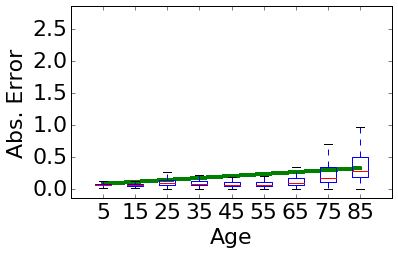

INFO:root:Filtering and ranking 33 sub-contexts
INFO:root:32 statistically significant sub-contexts
INFO:root:Size range: 91-22678
INFO:root:1 sub-contexts printed


p-value = 3.30e-179 ; CORR = [0.2057, 0.2432]

Sub-Population 2 of size 6252
Context = {'Treated at Urgent Care': (0.5, inf)}



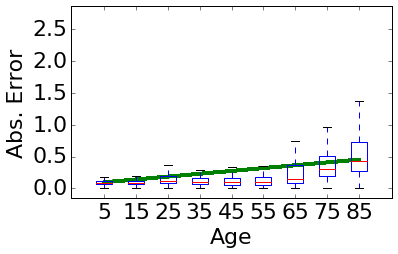

p-value = 1.85e-141 ; CORR = [0.2724, 0.3492]
--------------------------------------------------------------------------------

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [0.2057, 0.2432] ; Size = 28930
   Context = {'Treated at Urgent Care': (0.5, inf)} ; CI = [0.2724, 0.3492] ; Size = 6252
--------------------------------------------------------------------------------



[{}, {'Treated at Urgent Care': (0.5, inf)}]

In [13]:
import fairtest.modules.bug_report.report as rep
import fairtest.modules.bug_report.filter_rank as fr

imp.reload(rep)

output_dir = None
inv.report([exp1], dataname, output_dir=output_dir, filter_conf=0.95, node_filter=fr.FILTER_BETTER_THAN_ANCESTORS)

In [14]:
test_data = exp1.holdout._test_sets[1]
subpop = test_data[test_data['Treated at Urgent Care'] >= 0.5]

old = subpop[subpop['Age'] >= 61]
young = subpop[subpop['Age'] < 61]

print np.mean(abs(np.expm1(subpop['Prediction'])-np.expm1(subpop['Ground_Truth'])))
print np.mean(abs(np.expm1(old['Prediction'])-np.expm1(old['Ground_Truth'])))
print np.mean(abs(np.expm1(young['Prediction'])-np.expm1(young['Ground_Truth'])))
print

old = test_data[test_data['Age'] >= 61]
young = test_data[test_data['Age'] < 61]
print np.mean(abs(np.expm1(test_data['Prediction'])-np.expm1(test_data['Ground_Truth'])))
print np.mean(abs(np.expm1(old['Prediction'])-np.expm1(old['Ground_Truth'])))
print np.mean(abs(np.expm1(young['Prediction'])-np.expm1(young['Ground_Truth'])))

0.56478369859
1.07064641272
0.325089201795

0.417140703855
0.692929375572
0.256679921103


In [ ]:
#
# Test with explanatory feature on same tree
#

In [15]:
new_metrics = [{'Age': 'CondCorr'}]
new_expl = ['Pred Interval Size']
inv.test([exp1], exact=True, prune_insignificant=True, new_metrics=new_metrics, new_expl=new_expl)

INFO:root:Computing Absolute Regression Error
INFO:root:Parsing tree for sensitive feature Age...
INFO:root:Parsed tree for sensitive feature Age
INFO:root:Begin testing phase
INFO:root:Testing 33 hypotheses
INFO:root:Computing stats for 33 contexts
INFO:root:Computing stats for context 0
INFO:root:Computing stats for context 1
INFO:root:Computing stats for context 3
INFO:root:Computing stats for context 7
INFO:root:Computing stats for context 13
INFO:root:Computing stats for context 23
INFO:root:Computing stats for context 24
INFO:root:Computing stats for context 14
INFO:root:Computing stats for context 25
INFO:root:Computing stats for context 26
INFO:root:Computing stats for context 8
INFO:root:Computing stats for context 15
INFO:root:Computing stats for context 16
INFO:root:Computing stats for context 4
INFO:root:Computing stats for context 9
INFO:root:Computing stats for context 17
INFO:root:Computing stats for context 18
INFO:root:Computing stats for context 10
INFO:root:Computing

Report Creation time: 2016-11-17 14:35:10

Dataset: medical
Train Size: 28498
Test Size: 28930
S: ['Age']
X: ['Stdev Length Of Stay', 'Treated at Home', 'Supressed
	Length Of Stay', 'Condition RENAL1', 'No Lab Count',
	'Condition RENAL3', 'Condition RENAL2', 'Speciality
	Diagnostic Imaging', 'Lab Months', 'Number Of Claims', 'No
	Drug Count', 'Range Charlson IndexI_range', 'Number of
	Vendors', 'Number Of Specialties', 'Treated at Outpatient
	Hospital', 'Treatment Code RAD', 'Number of Procedure
	Groups', 'Condition INFEC4', 'Max Lab Count', 'Average Lab
	Count', 'Treated at Office', 'Pred Interval Size',
	'Condition PERVALV', 'Number of Places Where Treated',
	'Condition FXDISLC', 'Condition SEIZURE', 'Treatment Code
	SMCD', 'Treatment Code EM', 'Average Drug Count', 'Condition
	HEMTOL', 'Speciality NULL', 'Condition FLaELEC', 'Treatment
	Code SNS', 'Treatment Code SUS', 'Number of Primary
	Physicians', 'Condition NEUMENT', 'Speciality Laboratory',
	'Speciality Other', 'Average Paymen

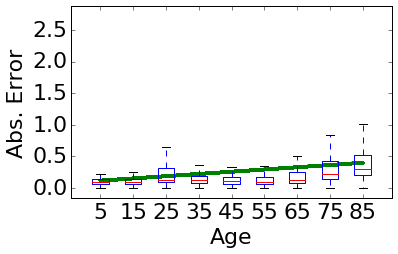

p-value = 2.27e-128 ; CORR = [0.1722, 0.2259]

> Pred Interval Size = low ; size 14449 (49.94%):


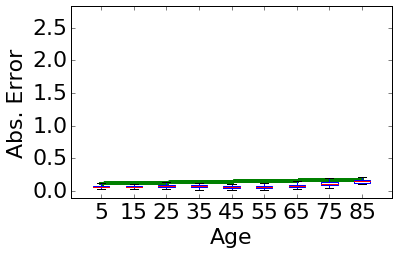

INFO:root:Filtering and ranking 33 sub-contexts
INFO:root:32 statistically significant sub-contexts
INFO:root:Size range: 87-22589
INFO:root:2 sub-contexts printed


p-value = 2.44e-13 ; CORR = [0.0377, 0.0934]

p-value = 1.26e-13 ; CondCORR = [0.1050, 0.1597]

Sub-Population 12 of size 1211
Context = {'Min Drug Count': (1.5, inf), 'Condition SKNAUT': (-inf, 4.5], 'Treated at Urgent Care': (0.5, inf)}

> Pred Interval Size = high ; size 979 (80.84%):


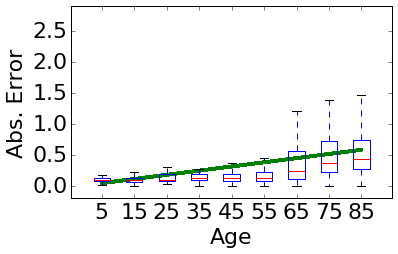

p-value = 7.50e-03 ; CORR = [0.2638, 0.4094]

> Pred Interval Size = low ; size 232 (19.16%):


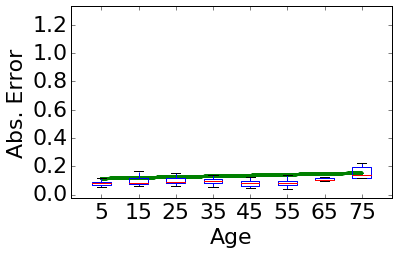

p-value = 1.00e+00 ; CORR = [-0.1311, 0.2835]

p-value = 1.00e+00 ; CondCORR = [0.1647, 0.4020]
--------------------------------------------------------------------------------

Sub-Population 2 of size 6341
Context = {'Treated at Urgent Care': (0.5, inf)}

> Pred Interval Size = high ; size 4351 (68.62%):


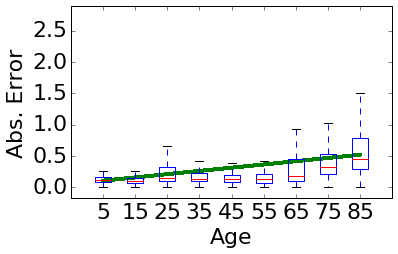

p-value = 1.03e-88 ; CORR = [0.2499, 0.3428]

> Pred Interval Size = low ; size 1990 (31.38%):


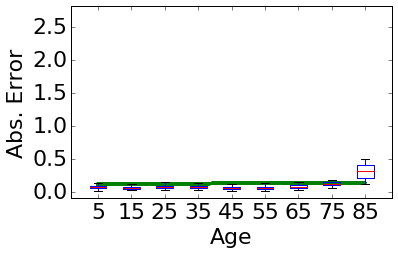

p-value = 1.00e+00 ; CORR = [-0.0558, 0.0948]

p-value = 1.00e+00 ; CondCORR = [0.1539, 0.2650]
--------------------------------------------------------------------------------

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [0.1050, 0.1597] ; Size = 28930
   Context = {'Treated at Urgent Care': (0.5, inf)} ; CI = [0.1539, 0.2650] ; Size = 6341
     Context = {'Min Drug Count': (1.5, inf), 'Condition SKNAUT': (-inf, 4.5], 'Treated at Urgent Care': (0.5, inf)} ; CI = [0.1647, 0.4020] ; Size = 1211
--------------------------------------------------------------------------------



[{},
 {'Treated at Urgent Care': (0.5, inf)},
 {'Condition SKNAUT': (-inf, 4.5],
  'Min Drug Count': (1.5, inf),
  'Treated at Urgent Care': (0.5, inf)}]

In [16]:
imp.reload(rep)
imp.reload(fr)

output_dir = None
inv.report([exp1], dataname, output_dir=output_dir, filter_conf=0, node_filter=fr.FILTER_BETTER_THAN_ANCESTORS)

In [ ]:
#
# Train a new tree with explanatory feature
#

In [ ]:
data_source = DataSource(data, random_state=RANDOM_SEED, budget=2, train_size=0.33)

EXPL='Pred Interval Size'
exp2 = error_profiling.ErrorProfiling(data_source, SENS, TARGET, GROUND_TRUTH, EXPL, random_state=RANDOM_SEED)
print 'Training set: {}/{}'.format(len(exp2.train_set), len(data))
exp2.train_set.tail()

In [ ]:
inv.train([exp2], score_aggregation='avg', min_leaf_size=100, max_depth=5)

In [ ]:
print exp2.trained_trees['Age']

In [ ]:
inv.test([exp2], exact=False, prune_insignificant=True)

In [ ]:
imp.reload(fr)
imp.reload(rep)

output_dir = None
inv.report([exp2], dataname, output_dir=output_dir, filter_conf=0.95, node_filter=fr.FILTER_ALL)